In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'pipeline')))
from pipeline.rapid_transformer import RapidTransformer

rt = RapidTransformer('initial')
rt.load()
desc_df = rt.desc_df
desc_df.columns

Index(['job_description', 'qualifications', 'responsibilities', 'benefits',
       'category', 'search', 'job_description_id', 'tech_keywords',
       'ml_keywords', 'devops_keywords', 'cloud_keywords', 'ai_group_keywords',
       'qual_keywords', 'cert_keywords', 'gov_keywords'],
      dtype='object')

In [2]:
import pandas as pd
parsed_df = pd.read_json("output/job_parsed/parsed_jobs.json.gzip", lines=True, compression='gzip')
parsed_df.drop(columns=['job_description'], inplace=True)

In [3]:
parsed_df.columns

Index(['job_title', 'job_category', 'core_technical_skills',
       'subject_area_specific_skills', 'soft_skills_and_mindset',
       'experience_level', 'expirience_years', 'education_level',
       'education_specialization', 'required_certifications',
       'salary_from_amt', 'salary_to_amt', 'it_tech_keywords', 'job_type',
       'remote', 'benefits', 'is_government_job', 'company_name',
       'company_industry', 'company_business_tasks', 'job_ids', 'file_name',
       'job_description_id'],
      dtype='object')

In [4]:
df = parsed_df.merge(desc_df, on='job_description_id', how='left', suffixes=('_openai', ''))
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, list)).any():
        df[col] = df[col].apply(lambda x: '|'.join(map(str, x)) if isinstance(x, list) else x)

df.fillna("", inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13357 entries, 0 to 13356
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   job_title                     13357 non-null  object 
 1   job_category                  13357 non-null  object 
 2   core_technical_skills         13357 non-null  object 
 3   subject_area_specific_skills  13357 non-null  object 
 4   soft_skills_and_mindset       13357 non-null  object 
 5   experience_level              13357 non-null  object 
 6   expirience_years              13357 non-null  int64  
 7   education_level               13357 non-null  object 
 8   education_specialization      13357 non-null  object 
 9   required_certifications       13357 non-null  object 
 10  salary_from_amt               13357 non-null  float64
 11  salary_to_amt                 13357 non-null  float64
 12  it_tech_keywords              13357 non-null  object 
 13  j

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans


ct = ColumnTransformer(
    transformers=[
        ("job_title", TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words=None, min_df=1), "job_title"),
        ("job_category", TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words=None, min_df=1), "job_category"),
        # ("category", TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words=None, min_df=1), "category"),
        # ("search", TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words=None, min_df=1), "search"),

        # ("core_technical_skills",  TfidfVectorizer(token_pattern=r"[^,;\|]+"), "core_technical_skills"), 
        # ("subject_area_specific_skills",  TfidfVectorizer(token_pattern=r"[^,;\|]+"), "subject_area_specific_skills"),  
        # ("soft_skills_and_mindset",  TfidfVectorizer(token_pattern=r"[^,;\|]+"), "soft_skills_and_mindset"),  
        # 
        # ("experience_level", TfidfVectorizer(ngram_range=(1,2), lowercase=True), "experience_level"),
        # ("education_level", TfidfVectorizer(ngram_range=(1,2), lowercase=True), "education_level"),
        # ("education_specialization", TfidfVectorizer(ngram_range=(1,2), lowercase=True), "education_specialization"),
        # ("required_certifications", TfidfVectorizer(token_pattern=r"[^,;\|]+"), "required_certifications"),
        # ("qualifications", TfidfVectorizer(token_pattern=r"[^,;\|]+"), "qualifications"),
        # ("responsibilities", TfidfVectorizer(token_pattern=r"[^,;\|]+"), "responsibilities"),
        # 
        # ("tech_keywords", TfidfVectorizer(token_pattern=r"[^,;\|]+"), "tech_keywords"),
        # ("ml_keywords", TfidfVectorizer(token_pattern=r"[^,;\|]+"), "ml_keywords"),
        # ("devops_keywords", TfidfVectorizer(token_pattern=r"[^,;\|]+"), "devops_keywords"),
        # ("cloud_keywords", TfidfVectorizer(token_pattern=r"[^,;\|]+"), "cloud_keywords"),
        # ("ai_group_keywords", TfidfVectorizer(token_pattern=r"[^,;\|]+"), "ai_group_keywords"),
        # ("qual_keywords", TfidfVectorizer(token_pattern=r"[^,;\|]+"), "qual_keywords"),
        # ("cert_keywords", TfidfVectorizer(token_pattern=r"[^,;\|]+"), "cert_keywords"),

    ],
    transformer_weights={"job_title": 3.0, "job_category": 1.0, "category": 1.0, "search": 1.0, "core_technical_skills": 1.5, "subject_area_specific_skills": 1.5, "soft_skills_and_mindset": 1.0, "experience_level": 1.0, "education_level": 1.0, "education_specialization": 1.0, "required_certifications": 1.0, "qualifications": 1.0, "responsibilities": 1.0, "tech_keywords": 1.5, "ml_keywords": 1.5, "devops_keywords": 1.5, "cloud_keywords": 1.5, "ai_group_keywords": 1.5, "qual_keywords": 1.0, "cert_keywords": 1.0},
)

pipe = make_pipeline(ct, TruncatedSVD(256, random_state=42), KMeans(n_clusters=20, n_init="auto", random_state=42))

X_encoded = pipe.named_steps['truncatedsvd'].fit_transform(ct.fit_transform(df))
kmeans = pipe.named_steps['kmeans']
labels = kmeans.fit_predict(X_encoded)

# Optionally, evaluate clustering quality
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(X_encoded, labels)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.11620615380790546


In [24]:
pd.Series(labels).value_counts().T

1     5661
19    3256
4      714
8      646
13     349
15     320
10     319
11     290
2      266
0      235
7      194
17     187
14     161
9      145
12     137
5      126
18     125
6      100
16      90
3       36
Name: count, dtype: int64

(13357, 2)


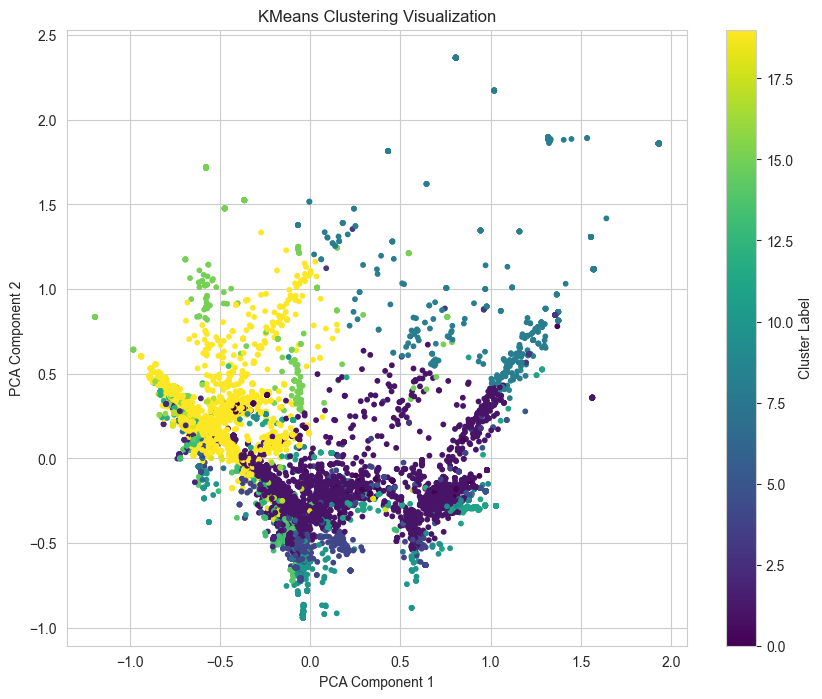

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_emb_2d = pca.fit_transform(X_encoded)
print(X_emb_2d.shape)
# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_emb_2d[:, 0], X_emb_2d[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(label='Cluster Label')
plt.title('KMeans Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [63]:
# clustering_text_anova.py
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
from typing import Dict, Any, Tuple, Optional, List

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import f_oneway


def _prepare_features(
        texts: pd.Series,
        max_features: int = 50_000,
        n_components: int = 100
) -> Tuple[np.ndarray, List[str]]:
    """
    Vectorize text with TF-IDF and reduce with TruncatedSVD.
    Returns dense embedding matrix (n_samples, n_components).
    """
    tfidf = TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        ngram_range=(1, 2),
        max_features=max_features,
        min_df=2
    )
    X_tfidf = tfidf.fit_transform(texts)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_svd = svd.fit_transform(X_tfidf)
    
    # Scale for distance-based clustering
    X = StandardScaler(with_mean=True, with_std=True).fit_transform(X_svd)
    return X, X_tfidf

def _filter_noise(labels: np.ndarray) -> np.ndarray:
    """Map labels to contiguous 0..K-1 and drop noise (-1) entries indicator."""
    mask = labels != -1
    return mask

def _cluster_metrics(X: np.ndarray, labels: np.ndarray) -> Dict[str, Optional[float]]:
    """
    Compute clustering metrics only when there are >=2 clusters and all labels valid.
    For metrics requiring >1 cluster, return None when not applicable.
    """
    unique = np.unique(labels[labels != -1]) if np.any(labels == -1) else np.unique(labels)
    k = len(unique)
    metrics = {"n_clusters": k, "n_noise": int(np.sum(labels == -1))}
    if k < 2:
        metrics.update({
            "silhouette": None,
            "calinski_harabasz": None,
            "davies_bouldin": None
        })
        return metrics

    # For metrics, exclude noise if present
    mask = labels != -1 if np.any(labels == -1) else np.ones_like(labels, dtype=bool)
    X_valid = X[mask]
    y_valid = labels[mask]
    try:
        metrics["silhouette"] = float(silhouette_score(X_valid, y_valid, metric="euclidean"))
    except Exception:
        metrics["silhouette"] = None
    try:
        metrics["calinski_harabasz"] = float(calinski_harabasz_score(X_valid, y_valid))
    except Exception:
        metrics["calinski_harabasz"] = None
    try:
        metrics["davies_bouldin"] = float(davies_bouldin_score(X_valid, y_valid))
    except Exception:
        metrics["davies_bouldin"] = None
    return metrics

def _anova_by_component(X: np.ndarray, labels: np.ndarray) -> Dict[str, Any]:
    """
    Run one-way ANOVA per SVD component across clusters.
    Returns summary stats: mean/median F, min p, share of p<0.05, and arrays.
    Excludes noise label (-1) if present. Requires >=2 non-empty clusters.
    """
    # Exclude noise
    mask = labels != -1 if np.any(labels == -1) else np.ones(len(labels), dtype=bool)
    Xv = X[mask]
    lv = labels[mask]
    unique = np.unique(lv)
    if len(unique) < 2:
        return {
            "anova_mean_F": None,
            "anova_median_F": None,
            "anova_min_p": None,
            "anova_prop_sig_p": None,
            "anova_F_per_component": None,
            "anova_p_per_component": None,
        }

    F_vals = []
    p_vals = []
    for j in range(Xv.shape[1]):
        groups = [Xv[lv == c, j] for c in unique]
        # Ensure groups are not empty and have variance
        if any(len(g) < 2 for g in groups):
            F_vals.append(np.nan)
            p_vals.append(np.nan)
            continue
        try:
            F, p = f_oneway(*groups)
            F_vals.append(F)
            p_vals.append(p)
        except Exception:
            F_vals.append(np.nan)
            p_vals.append(np.nan)

    F_arr = np.array(F_vals, dtype=float)
    p_arr = np.array(p_vals, dtype=float)
    valid = np.isfinite(F_arr) & np.isfinite(p_arr)
    if not np.any(valid):
        return {
            "anova_mean_F": None,
            "anova_median_F": None,
            "anova_min_p": None,
            "anova_prop_sig_p": None,
            "anova_F_per_component": F_vals,
            "anova_p_per_component": p_vals,
        }

    Fv = F_arr[valid]
    pv = p_arr[valid]
    return {
        "anova_mean_F": float(np.nanmean(Fv)),
        "anova_median_F": float(np.nanmedian(Fv)),
        "anova_min_p": float(np.nanmin(pv)),
        "anova_prop_sig_p": float(np.mean(pv < 0.05)),
        "anova_F_per_component": F_vals,
        "anova_p_per_component": p_vals,
    }

def run_clustering(model, X, name, df):
    labels = model.fit_predict(X)
    df[name] = labels
    km_metrics = _cluster_metrics(X, labels)
    km_anova = _anova_by_component(X, labels)
    print(df[name].value_counts().T)
    return {
        "algorithm": name,
        **km_metrics,
        **{k: v for k, v in km_anova.items() if not isinstance(v, list)}  # keep summary stats only
    }

X_emb, X_TFIDF = _prepare_features(train["combined_text"], n_components=100)

def run_all_clusterings(
        df: pd.DataFrame,
        X_emb: np.ndarray,
        kmeans_k: int = 8,
        agglom_k: int = 8,
        dbscan_eps: float = 1.5,
        dbscan_min_samples: int = 3,
        hdbscan_min_cluster_size: int = 5,
        random_state: int = 42
) -> Tuple[pd.DataFrame, Dict[str, np.ndarray]]:

    results = []
    
    km1 = KMeans(n_clusters=kmeans_k, n_init="auto", random_state=random_state)
    r1 = run_clustering(km1, X_emb, "kmeans", df)

    ag1 = AgglomerativeClustering(n_clusters=agglom_k, linkage="ward")
    r3 = run_clustering(ag1, X_emb, "agglomerative", df)

    db1 = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric="euclidean", n_jobs=-1)
    r5 = run_clustering(db1, X_emb, "dbscan", df)
    
    hdb1 = HDBSCAN(min_cluster_size=hdbscan_min_cluster_size, metric="euclidean")
    r7 = run_clustering(hdb1, X_emb, "hdbscan", df)
    results.extend([r1, r3, r5, r7])
    
    summary_df = pd.DataFrame(results)
    return summary_df


summary = run_all_clusterings(
    train,
    X_emb,
    kmeans_k=15,
    agglom_k=15
)
print(summary.to_string(index=False))


kmeans
14    4555
7      786
12     708
6      540
4      537
10     491
8      487
1      437
3      427
9      411
13     305
2      236
0      224
5      198
11      52
Name: count, dtype: int64
agglomerative
0     6681
1     1130
4      804
3      265
2      237
6      195
7      187
5      178
12     152
11     129
8      116
9      107
10      97
14      76
13      40
Name: count, dtype: int64
dbscan
-1    10389
 0        5
Name: count, dtype: int64
hdbscan
 1    9227
-1    1152
 2       8
 0       7
Name: count, dtype: int64
    algorithm  n_clusters  n_noise  silhouette  calinski_harabasz  davies_bouldin  anova_mean_F  anova_median_F  anova_min_p  anova_prop_sig_p  anova_F_per_component  anova_p_per_component
       kmeans          15        0    0.036294          91.062211        3.986716    138.179064       32.844351 0.000000e+00              1.00                    NaN                    NaN
agglomerative          15        0    0.041583          90.879191        3.072878   

In [ ]:



from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer

m = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
E_title = m.encode(df["title"].tolist(), normalize_embeddings=True)
E_body  = m.encode(df["body"].tolist(),  normalize_embeddings=True)
E_tags  = m.encode(df["tags"].tolist(),  normalize_embeddings=True)

E = normalize(2.0*E_title + 1.0*E_body + 1.5*E_tags)

In [64]:
X_TFIDF.shape

(10394, 50000)

(10394, 2)


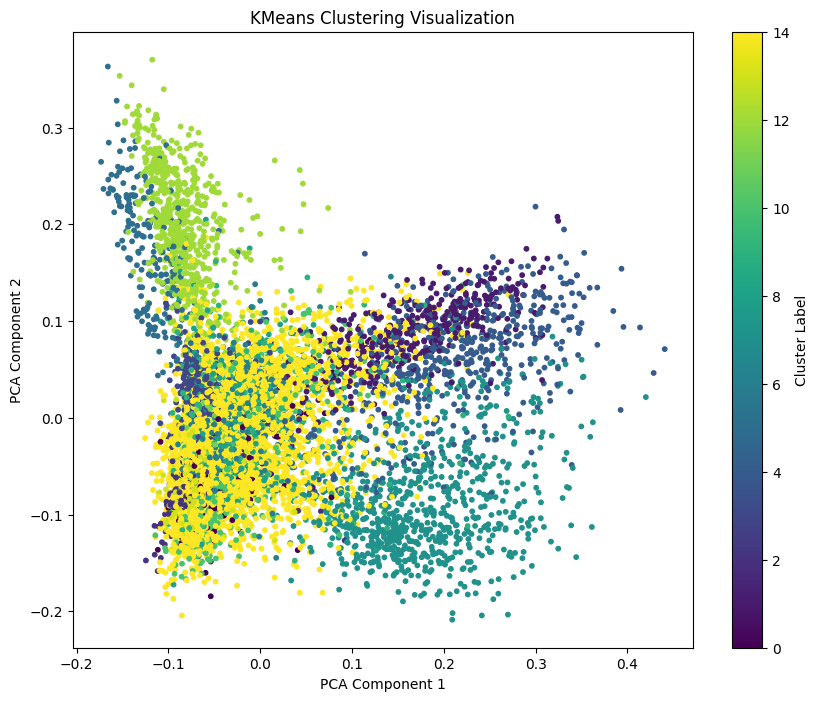

In [68]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_emb_2d = pca.fit_transform(X_TFIDF)
print(X_emb_2d.shape)
# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_emb_2d[:, 0], X_emb_2d[:, 1], c=train['kmeans'], cmap='viridis', s=10)
plt.colorbar(label='Cluster Label')
plt.title('KMeans Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

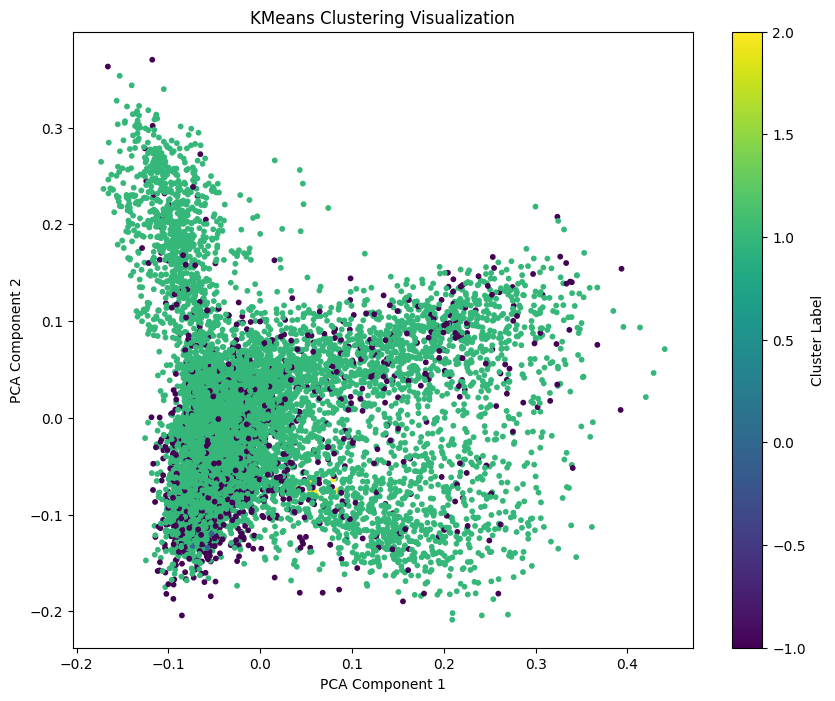

In [66]:
# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_emb_2d[:, 0], X_emb_2d[:, 1], c=train['hdbscan'], cmap='viridis', s=10)
plt.colorbar(label='Cluster Label')
plt.title('KMeans Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [89]:
clusters = {}
for cluster_label in train['kmeans'].unique():
    clusters['kmeans_' + str(cluster_label)] = train[train['kmeans'] == cluster_label]['job_id'].to_list()

for cluster_label in train['agglomerative'].unique():
    clusters['agglo_' + str(cluster_label)] = train[train['agglomerative'] == cluster_label]['job_id'].to_list()
type(clusters)

dict

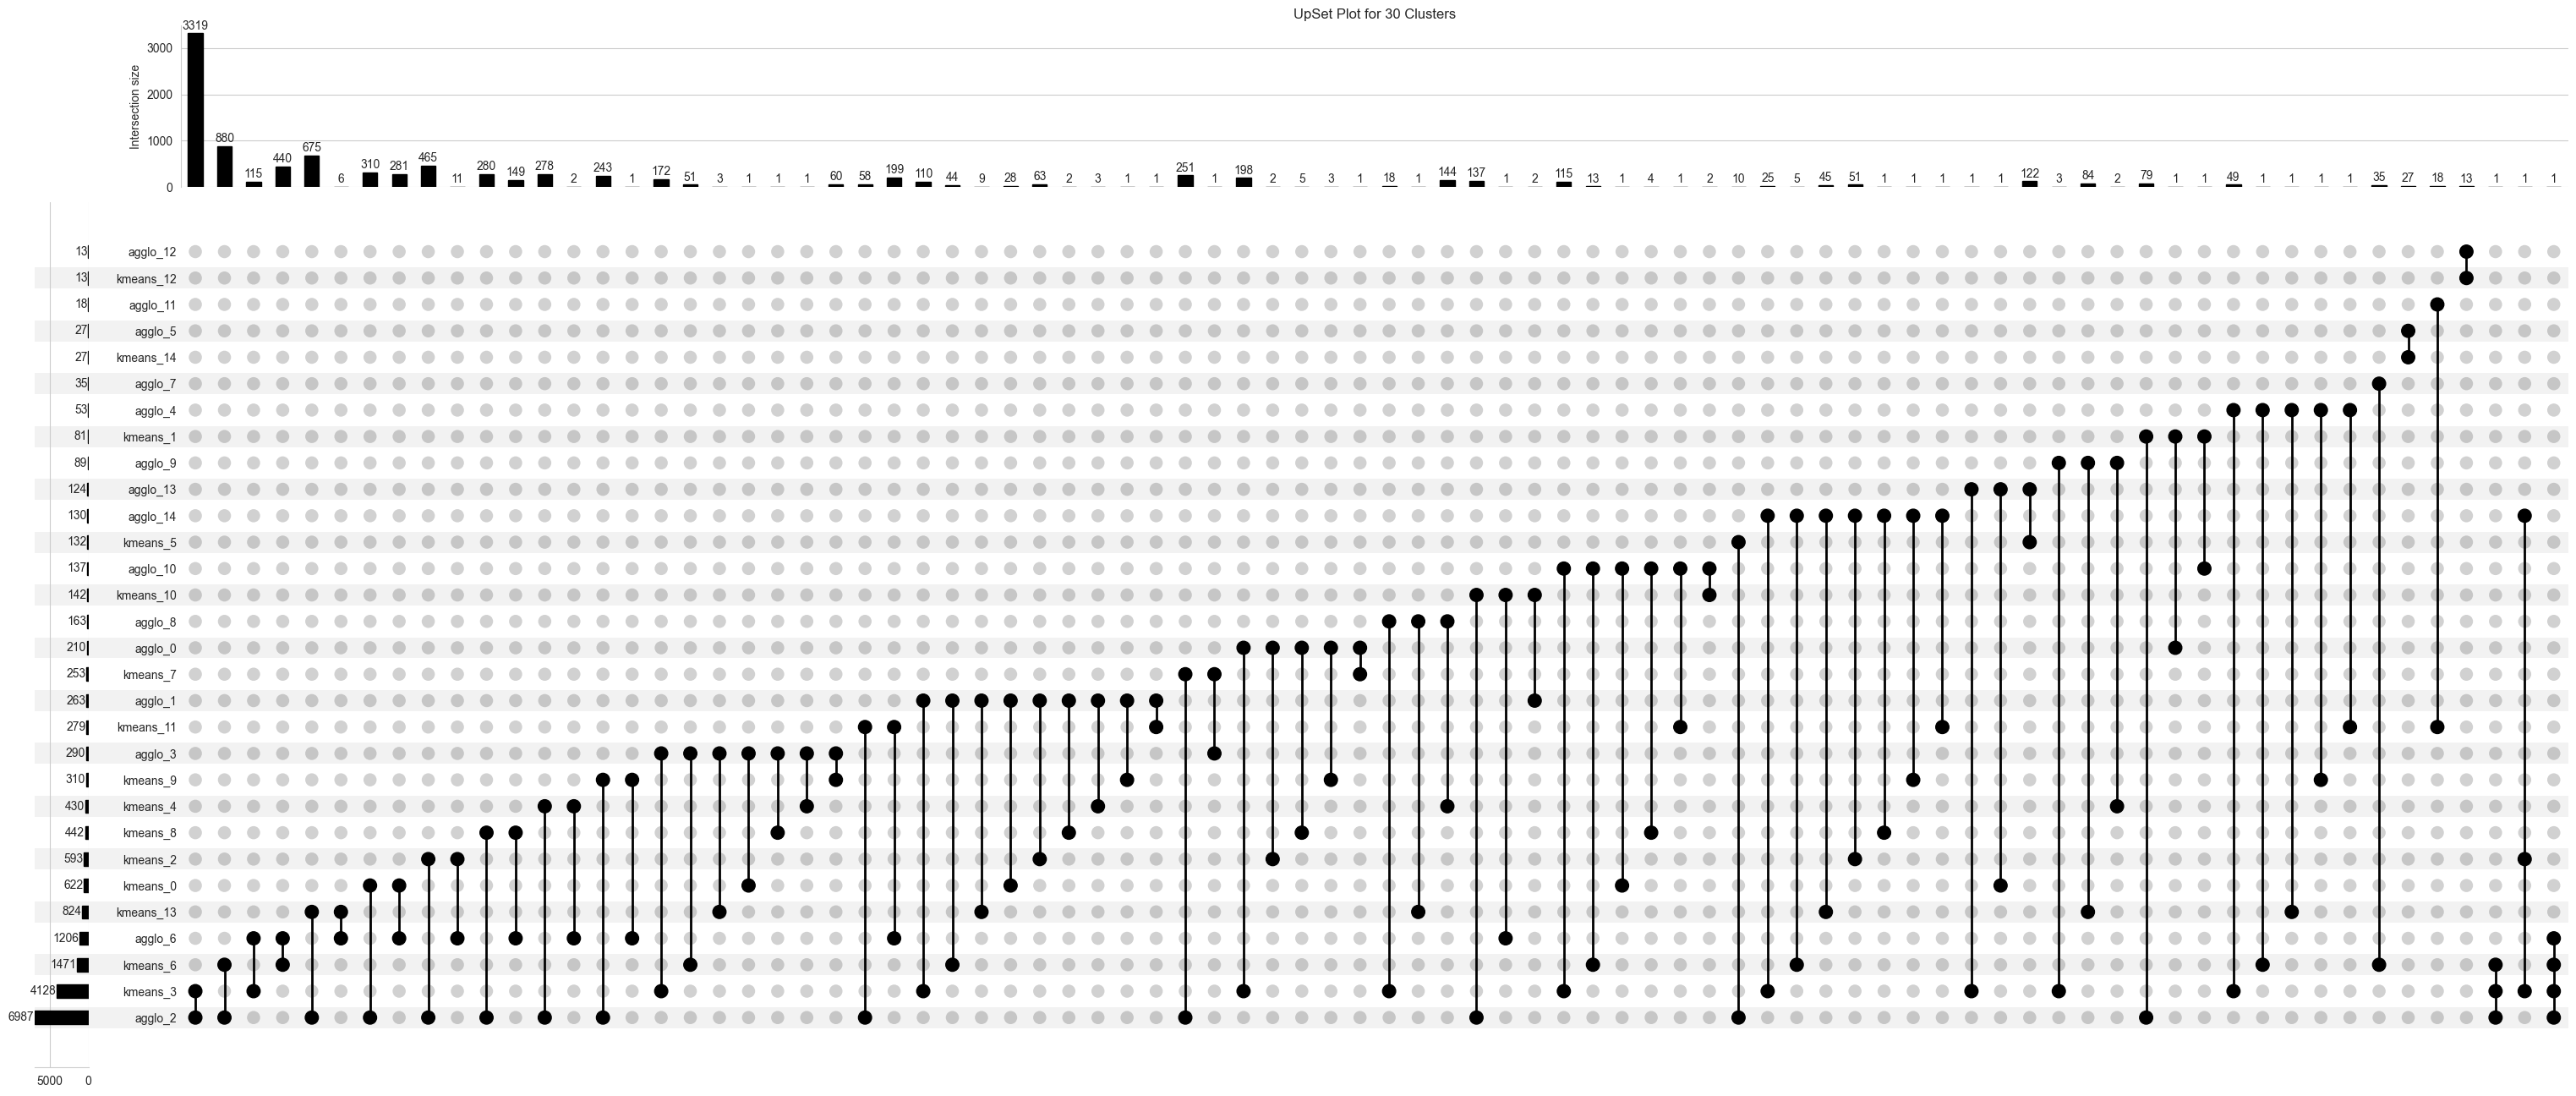

In [90]:
import pandas as pd
from upsetplot import UpSet
import matplotlib.pyplot as plt

all_items = set.union(*[set(v) for v in clusters.values()])
data = []
for item in all_items:
    row = {key: item in cluster for key, cluster in clusters.items()}
    row['item'] = item
    data.append(row)

df = pd.DataFrame(data).set_index(list(clusters.keys()))

# Plot the UpSet plot
upset = UpSet(df, subset_size='count', show_counts=True)
upset.plot()
plt.title("UpSet Plot for 30 Clusters")
plt.show()

In [91]:
df

item
kmeans_0 kmeans_8 kmeans_6 kmeans_3 kmeans_2 kmeans_11 kmeans_10 kmeans_4 kmeans_1 kmeans_5 kmeans_9 kmeans_13 kmeans_12 kmeans_7 kmeans_14 agglo_6 agglo_2 agglo_10 agglo_1 agglo_13 agglo_11 agglo_8 agglo_3 agglo_12 agglo_14 agglo_0 agglo_9 agglo_4 agglo_7 agglo_5                          
False    False    False    True     False    False     False     False    False    False    False    False     False     False    False     False   True    False    False   False    False    False   False   False    False    False   False   False   False   False    M01MforLiWXNZ8YLAAAAAA==
                  True     False    False    False     False     False    False    False    False    False     False     False    False     False   True    False    False   False    False    False   False   False    False    False   False   False   False   False    fbrcUARjYQj8h1vfAAAAAA==
         True     False    False    False    False     False     False    False    False    False    False     False     False    False     True    False   False    False   False    False    False   False   False    False    False   False   False   False   False    sW2885AmSo7M_QPzAAAAAA==
         False    False    False    False    False     False     False    False    False    False    True      False     False    False     False   True    False    False   False    False    False   False   False    False    False   False   False   False   False    0GOG9wf8144Yjb61AAAAAA==
                                                                                                                                                                                                                                                                 False    OE3itW0Ng8y56ZfNAAAAAA==
...                                                                                                                                                                                                                                                                                            ...
                                             True      False     False    False    False    False    False     False     False    False     False   False   False    False   False    True     False   False   False    False    False   False   False   False   False    E8KnFlGcdfjtSTqlAAAAAA==
                  True     False    False    False     False     False    False    False    False    False     False     False    False     False   True    False    False   False    False    False   False   False    False    False   False   False   False   False    szf4Sg8M_NoGeUFrAAAAAA==
                  False    True     False    False     False     False    False    False    False    False     False     False    False     False   True    False    False   False    False    False   False   False    False    False   False   False   False   False    22ZuE4HZYswcNJnhAAAAAA==
True     False    False    False    False    False     False     False    False    False    False    False     False     False    False     False   True    False    False   False    False    False   False   False    False    False   False   False   False   False    XGEERBqlrOO3vkSkAAAAAA==
False    False    False    True     False    False     False     False    False    False    False    False     False     False    False     False   True    False    False   False    False    False   False   False    False    False   False   False   False   False    mw2TG5WQaVL41Mn5AAAAAA==

[9744 rows x 1 columns]

In [92]:
train[train['kmeans'] == 12]

,job_id,norm_title,it_tech_keywords,combined_text,kmeans,agglomerative,dbscan,hdbscan
887,ll-5iUuYPRY1In0AAAAAAA==,cloud engineer,"[Enterprise Scale Hosting, Healthcare Technolo...","cloud engineer Enterprise Scale Hosting,Health...",12,12,-1,1
888,ll-5iUuYPRY1In0AAAAAAA==,cloud engineer,"[Enterprise Scale Hosting, Healthcare Technolo...","cloud engineer Enterprise Scale Hosting,Health...",12,12,-1,1
3360,jDoxqlXKJaYP6P3lAAAAAA==,security engineer,"[Enterprise Scale Hosting, Healthcare Technolo...","security engineer Enterprise Scale Hosting,Hea...",12,12,-1,1
3361,jDoxqlXKJaYP6P3lAAAAAA==,security engineer,"[Enterprise Scale Hosting, Healthcare Technolo...","security engineer Enterprise Scale Hosting,Hea...",12,12,-1,1
3605,TAa9Oc-rAB5uNZ8LAAAAAA==,devops engineer,"[Enterprise Scale Hosting, Healthcare Technolo...","devops engineer Enterprise Scale Hosting,Healt...",12,12,57,2
3606,TAa9Oc-rAB5uNZ8LAAAAAA==,devops engineer,"[Enterprise Scale Hosting, Healthcare Technolo...","devops engineer Enterprise Scale Hosting,Healt...",12,12,57,2
3683,SON_fwZQrN4xLgxwAAAAAA==,devops engineer,"[Enterprise Scale Hosting, Healthcare Technolo...","devops engineer Enterprise Scale Hosting,Healt...",12,12,57,2
3684,SON_fwZQrN4xLgxwAAAAAA==,devops engineer,"[Enterprise Scale Hosting, Healthcare Technolo...","devops engineer Enterprise Scale Hosting,Healt...",12,12,57,2
5478,prcoNsdC1RH9aSktAAAAAA==,devops engineer,"[Enterprise Scale Hosting, Healthcare Technolo...","devops engineer Enterprise Scale Hosting,Healt...",12,12,57,2
5516,4spcwelCqu8FUX6eAAAAAA==,devops engineer,"[Enterprise Scale Hosting, Healthcare Technolo...","devops engineer Enterprise Scale Hosting,Healt...",12,12,57,2
